# Synthetic Data Generation: Libraries Comparison

In this notebook we will compare two of the most prominent Python Packages for data generation: SDV and YData. The study will compare the creation of syntetic data from single table, and therefore creating single table as output.
Moreover, I'll create a small Generative Adversarial Network to create synthetic data and compare this simple model with the state-of-art models.

First of all, let's import all the needed libraries.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer
from ydata.sdk.dataset import get_dataset
from ydata.sdk.synthesizers import RegularSynthesizer
from sdv.metadata import Metadata

Let's start by importing the data we'll use (Fraud detection dataset from Kaggle Competition)

In [31]:
# Importing the training dataset that we will use to create syntethic data
training_df = pd.read_csv("Datasets/ieee-fraud-detection/train_transaction.csv", nrows=10000) # Taking only the first 10.000 rows for memory limitation

# Inspect data 
print(training_df.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN  

Inspecting the data (Handling missing values)

In [32]:
# Missing values
miss_info = training_df.isnull().sum()

treshold = 0.5 * len(training_df)
missing_column_count = 0
for col, missing_count in miss_info.items():
    if missing_count > treshold:
        missing_column_count += 1
        
print(f"There are {missing_column_count} columns with more than {int(treshold)} missing values")

# Drop these features
training_df = training_df.dropna(axis=1, thresh=treshold)
print(training_df.head())

There are 208 columns with more than 5000 missing values
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...   V312  V313  V314 V315  V316    V317  \
0    NaN  150.0    discover  142.0  ...    0.0   0.0   0.0  0.0   0.0   117.0   
1  404.0  150.0  mastercard  102.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
2  490.0  150.0        visa  166.0  ...    0.0   0.0   0.0  0.0   0.0     0.0   
3  567.0  150.0  mastercard  117.0  ...  135.0   0.0   0.0  0.0  50.0  1404.0   
4  514.0  150.0  mastercard  102.0  ...    0.0   0.0   0.0  0.0   0.0     0

How many missing values are still there?

In [33]:
# Missing values after feature removal
print(training_df.isnull().sum().sum())

# Since many rows have still missing values, impute data with median (numerical) and mode (categorical)
# If rows have too many missing values, drop them
row_threshold = 0.7 * len(training_df.columns)  
training_df.dropna(thresh=row_threshold, inplace=True)

# Impute remaining missing values systematically
training_df = training_df.apply(lambda col: col.fillna(col.mode()[0]) if col.dtype == "object" else col.fillna(col.median()))

print(training_df.isnull().sum().sum())

183863
0


Let's visualize the distribution of transaction amount present in the dataset

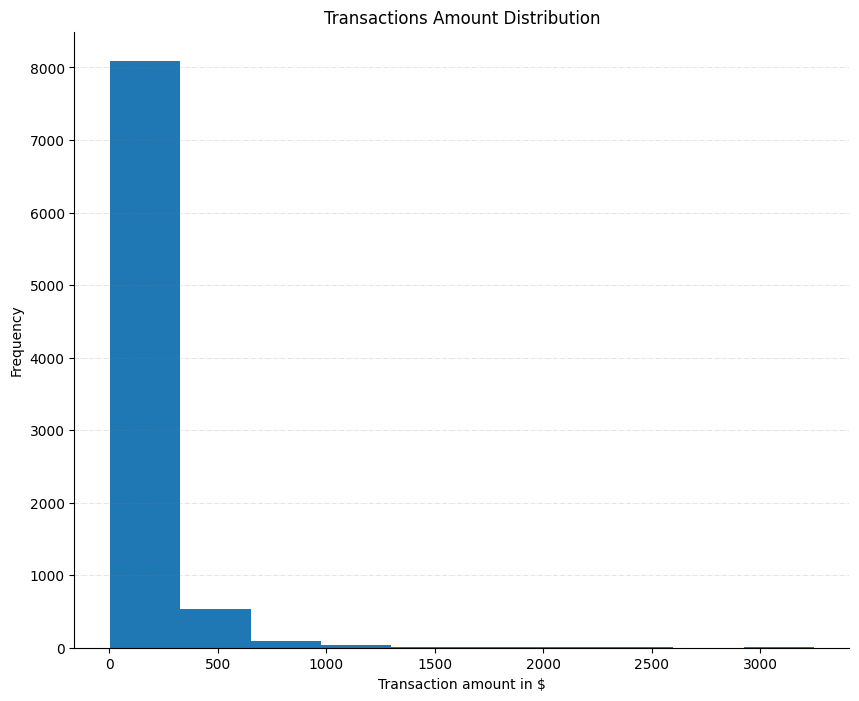

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist(training_df["TransactionAmt"])
ax.set_xlabel("Transaction amount in $")
ax.set_ylabel("Frequency")
ax.set_title("Transactions Amount Distribution")
ax.grid(visible=True, color="grey", linestyle="-.", linewidth=0.5, alpha=0.3, axis="y")
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 
plt.show()

The transaction amount is really right-skwed, since many daily transactions don't require a large amount of money

Now let's start by analyzing the first package: SDV. To use this package correctly we should first create the metadata for the current dataset. This metadata will then be used in the creation of the synthetic data.

In [35]:
# Create Metadata
metadata = Metadata.detect_from_dataframe(
    data=training_df,
    table_name="Fraud_detection")

print(metadata)

{
    "tables": {
        "Fraud_detection": {
            "columns": {
                "TransactionID": {
                    "sdtype": "id"
                },
                "isFraud": {
                    "sdtype": "categorical"
                },
                "TransactionDT": {
                    "sdtype": "numerical"
                },
                "TransactionAmt": {
                    "sdtype": "numerical"
                },
                "ProductCD": {
                    "sdtype": "categorical"
                },
                "card1": {
                    "sdtype": "numerical"
                },
                "card2": {
                    "sdtype": "numerical"
                },
                "card3": {
                    "sdtype": "numerical"
                },
                "card4": {
                    "sdtype": "categorical"
                },
                "card5": {
                    "sdtype": "numerical"
                },
                "c

After creating the metadata we can create the syntethizer. This is the description of a synthetizer that can be found in the SDV documentation page: 

"The SDV creates synthetic data using machine learning. A synthesizer is an object that you can use to accomplish this task.

1. You'll start by creating a synthesizer based on your metadata

2. Next, you'll train the synthesizer using real data. In this phase, the synthesizer will learn patterns from the real data.

2. Once your synthesizer is trained, you can use it to generate new, synthetic data."

There are different type of synthesizer, Each synthesizer uses a different machine learning technique for training. In this study we will try:
- GaussianCopulaSynthesizer: The Gaussian Copula Synthesizer uses classic, statistical methods to train a model and generate synthetic data.
- CTGANSynthesizer: The CTGAN Synthesizer uses GAN-based, deep learning methods to train a model and generate synthetic data.
- TVAESynthesizer: The TVAE Synthesizer uses a variational autoencoder (VAE)-based, neural network techniques to train a model and generate synthetic data.

We'll start with the GaussianCopulaSynthesizer.

In [36]:
# Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
# Training
synthesizer.fit(training_df)

# Syntetic data generation
synthetic_data = synthesizer.sample(num_rows=10)
print(synthetic_data)

c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        1496128        0         273664          50.786         W   5173   
1       12043917        0         304254          25.666         W   5663   
2        9006145        0         249052           3.134         W   9240   
3       14380721        0         138659          71.940         W   3254   
4        1649687        0         257537           7.988         W   5272   
5       12116237        0         170997          99.734         W   3039   
6        9804906        0         267797          74.556         H   3215   
7        8788379        0         152343          14.846         W  15660   
8        8191746        0         185329          37.720         C   4807   
9        5263048        0         127816          24.446         W   2254   

   card2  card3       card4  card5  ...        V312        V313        V314  \
0  413.0  158.0  mastercard  236.0  ...  141.964688  192.971010  274.1947